In [1]:
from random import randint
from string import Template
import json
from dataclasses import dataclass, make_dataclass, fields
import os
import shutil
import sqlite3
from contextlib import contextmanager
import threading

import graphviz
from IPython.display import Image

In [2]:
def all_subclasses(cls):
    return list(set(cls.__subclasses__()).union(
        [s for c in cls.__sublcasses__() for s in all_subclasses(c)]))

In [ ]:
DB_LOCK = threading.Lock()

In [3]:
class Graph:
    conn = None
    graph_name = "DMA"

    @contextmanager
    def cursor(self):
        self.__connect__()
        cur = self.conn.cursor()
        cur.execute("PRAGMA journal_mode=WAL")
        cur.execute("PRAGMA synchronous=NORMAL")
        yield cur
        cur.close()
        self.conn.close()
        self.conn = None
    
    def __connect__(self):
        # self.conn = sqlite3.connect("file:dma?mode=memory&cache=shared", uri=True, check_same_thread=False)
        if self.conn is None:
            self.conn = sqlite3.connect(
                "file:harmony.db?cache=shared",
                uri=True,
                check_same_thread=False,
                timeout=5)

    def reset(self):
        with self.cursor() as cur:
            cur.execute("DROP TABLE IF EXISTS edges;")
            cur.execute("""CREATE TABLE edges (
                start_node TEXT NOT NULL,
                edge_name TEXT NOT NULL,
                end_node TEXT NOT NULL,
                UNIQUE(start_node, edge_name) ON CONFLICT REPLACE);""")
            self.conn.commit()
    
    def __init__(self):
        self.conn = None

    def put(self, start_node, edge_name, end_node):
        with DB_LOCK, self.cursor() as cur:
            cur.execute(f"INSERT INTO edges VALUES ('{start_node}', '{edge_name}', '{end_node}')")
            self.conn.commit()

    def drop(self, start_node, edge_name, end_node):
        with DB_LOCK, self.cursor() as cur:
            try:
                cur.execute(f"DELETE FROM edges WHERE edge_name = '{edge_name}' AND start_node = '{start_node}' and end_node = '{end_node}'")
            except Exception:
                raise Exception(f"Failed to drop edge {start_node}-{edge_name}-{end_node}")
            self.conn.commit()

    def get(self,
        start_node: str | list | None = None,
        edge_name: str | list | None = None,
        end_node: str | list | None = None):
        query = f"SELECT * FROM edges"
        where_clause = ""
        for node_name, nodes in {"start_node": start_node, "edge_name": edge_name, "end_node": end_node}.items():
            if nodes is None:
                continue
            elif not isinstance(nodes, list):
                nodes = [nodes]
            nodes = [n for n in nodes if n is not None]
            if len(nodes) == 0:
                continue

            where_clause = " WHERE " if where_clause == "" else f"{where_clause} AND "
            
            node_clause = "("
            for node in nodes:
                if " = " in node_clause:
                    node_clause = f"{node_clause} OR"
                node_clause = f"{node_clause} {node_name} = '{node}'"
            where_clause = f"{where_clause}{node_clause})"
        
        query = f"{query}{where_clause}"
        try:
            with DB_LOCK, self.cursor() as cur:
                results = cur.execute(query).fetchall()
        except Exception as e:
            raise Exception(f"Failed to resolve query: {query}") from e
        return results

    def start_entities(self, member_edges: list):
        edge_list = ", ".join([f"'{me}'" for me in member_edges])
        with DB_LOCK, self.cursor() as cur:
            results = cur.execute(f"SELECT start_node FROM edges WHERE edge_name in ({edge_list})").fetchall()
        return list(set([r[0] for r in results]))

    def end_entities(self, member_edges: list):
        edge_list = ", ".join([f"'{me}'" for me in member_edges])
        with DB_LOCK, self.cursor() as cur:
            results = cur.execute(f"SELECT end_node FROM edges WHERE edge_name in ({edge_list})").fetchall()
        return list(set([r[0] for r in results]))

    def entities(self, member_edges: list):
        return list(set(self.start_entities(member_edges) + self.end_entities(member_edges)))

    def replace(self, start_node, edge_name, old_end_node, new_end_node):
        try:
            self.drop(start_node, edge_name, old_end_node)
        except Exception as e:
            raise Exception(f"Failed to drop existing edge. Cannot replace") from e
        self.put(start_node, edge_name, new_end_node)

    def rename(self, entity, newEntity):
        start_nodes = self.get(start_node=entity)
        for node in start_nodes:
            self.drop(*node)
            self.put(newEntity, node[1], node[2])
            
        end_nodes = self.get(end_node=entity)
        for node in end_nodes:
            self.drop(*node)
            self.put(node[0], node[1], newEntity)
        
    def whole_graph(self):
        return self.get()
    
    def render(self):
        def color_selector(value, color_set='node'):
            edge_set = ["black", "royalblue1", "slateblue", "coral"]
            node_set = ["red", "webmaroon", "green", "chartreuse4", "aquamarine4"]
            color_set = node_set if color_set == 'node' else edge_set
            try:
                float(value)
                return "purple"
            except ValueError:
                pass
            
            if value not in color_selector.color_map:
                color_selector.color_map[value] = color_set[randint(0, len(color_set) - 1)]

            return color_selector.color_map[value]
        
        color_selector.color_map = {}

        vg =  graphviz.Digraph("DMA", engine="neato", format="png")
        nodes = []
        whole_graph = self.whole_graph()
        for rel in whole_graph:
            if rel[0] not in nodes:
                vg.node(rel[0], color=color_selector(rel[0]))
                nodes.append(rel[0])
            if rel[2] not in nodes:
                vg.node(rel[2], color=color_selector(rel[2]))
                nodes.append(rel[2])
            vg.edge(rel[0], rel[2], label=rel[1], color=color_selector(rel[1], color_set="edge"), len='2')

        return vg

    def write_graph_file(self, graph_file=None):
        whole_graph = self.whole_graph()
        graph_file = graph_file or f"./{self.graph_name}.graph"
        with open(graph_file, "w") as f:
            f.write(json.dumps(whole_graph))

    @classmethod
    def read_graph_file(cls, graph_file=None):
        graph_file = graph_file or f"./{cls.graph_name}.graph"
        with open(graph_file, "r") as f:
            raw_graph = json.loads(f.read())
        new_graph = cls()
        for edge in raw_graph:
            new_graph.put(*edge)
        return new_graph

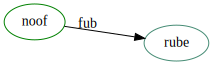

In [4]:
if __name__ == "__main__":
    from IPython.display import display
    graph = Graph()
    graph.reset()
    graph.put("foo", "bar", "roo")
    graph.put("foo", "fub", "rub")
    graph.put("foo", "bar", "rube")
    assert str(graph.whole_graph()) == "[('foo', 'fub', 'rub'), ('foo', 'bar', 'rube')]"
    graph.drop("foo", "bar", "rube")
    graph.replace("foo", "fub", "rub", "rube")
    assert str(graph.whole_graph()) == "[('foo', 'fub', 'rube')]"
    assert graph.start_entities(member_edges=['fub']) == ['foo']

    old_whole_graph = graph.whole_graph()
    graph.write_graph_file()
    new_graph = Graph.read_graph_file()
    new_whole_graph = new_graph.whole_graph()

    assert old_whole_graph == new_whole_graph

    new_graph.rename("foo", "noof")
    
    display(new_graph.render())

In [5]:
class QuantumSystem:
    quantum_system_name = "DMA"
    graph = Graph()
    t = 0
    
    @classmethod
    def get_system(cls, name):
        for system in cls.MetaSystem.all_metasystems():
            if system.__name__ == name:
                return system
        
        for system in cls.HyperSystem.all_hypersystems():
            if system.__name__ == name:
                return system
        
        for system in cls.System.all_systems():
            if system.__name__ == name:
                return system

        raise Exception(f"Unknown system: {name}")

    @classmethod
    def reset(cls):
        cls.graph.reset()
    
    @classmethod
    def whole_graph(cls):
        return cls.graph.whole_graph()

    @classmethod
    def write_graph_file(cls):
        cls.graph.write_graph_file(f"./{cls.quantum_system_name}.graph")

    @classmethod
    def read_graph_file(cls, graph_file=None):
        cls.graph = Graph.read_graph_file(f"./{cls.quantum_system_name}.graph")

    @classmethod
    def add_entity(cls, entity, **relationships):
        for rel_name, rel_value in relationships.items():
            cls.graph.put(entity, rel_name, rel_value)

    @classmethod
    def rename_entity(cls, entity, newEntity):
        cls.graph.rename(entity, newEntity)

    @classmethod
    def edge_list_to_names(cls, edge_name):
        if edge_name is not None:
            if not isinstance(edge_name, list):
                edge_name = [edge_name]
            edge_name = [en.__name__ if not isinstance(en, str) else en for en in edge_name]
        return edge_name
    
    @classmethod
    def get(cls, entity=None, edge_name=None, terminant=None):
        edge_name = cls.edge_list_to_names(edge_name)
        kwargs = {"start_node": entity, "edge_name": edge_name, "end_node": terminant}
        return cls.graph.get(**kwargs)

    @classmethod
    def start_entities(cls, member_systems=None):
        member_systems = cls.edge_list_to_names(member_systems)
        return cls.graph.start_entities(member_edges=member_systems)

    @classmethod
    def end_entities(cls, member_systems=None):
        member_systems = cls.edge_list_to_names(member_systems)
        return cls.graph.end_entities(member_edges=member_systems)

    @classmethod
    def entities(cls, member_systems=None):
        member_systems = cls.edge_list_to_names(member_systems)
        return cls.graph.entities(member_edges=member_systems)
    
    @classmethod
    def put(cls, entity, edge_name, terminant):
        if type(edge_name) is type:
            edge_name = edge_name.__name__
        cls.graph.put(entity, edge_name, terminant)
    
    @classmethod
    def drop(cls, entity, edge_name, terminant):
        if type(edge_name) is type:
            edge_name = edge_name.__name__
        cls.graph.drop(entity, edge_name, terminant)
    
    @classmethod
    def replace(cls, entity, edge_name, old_terminant, new_terminant):
        if type(edge_name) is type:
            edge_name = edge_name.__name__
        cls.graph.replace(entity, edge_name, old_terminant, new_terminant)
    
    @classmethod
    def validate(cls):
        results = {}
        for system in list(cls.System.all_systems()) + list(cls.HyperSystem.all_hypersystems()):
            try:
                system.validate()
            except Exception as exc:
                    results[system.__name__] = exc
        return results
    
    @classmethod
    def render(cls):
        return cls.graph.render()

qs = QuantumSystem

In [6]:
@dataclass
class Entity:
    """ An Entity is an anchor onto which Systems and HyperSystems attach """
    entity: str

    @classmethod
    def system_decorator(cls, system):
        system_list = system.systems
        if system_list is None:
            system_list = [cls]
        else:
            system_list.append(cls)
        sys_fields = [(f.name, f.type, f.default) for f in fields(system)]
        sys_fields.append((cls.__name__, cls, None))
        system = make_dataclass(system.__name__, sys_fields, bases=(system,))
        setattr(system, "systems", system_list)
        for sys in system_list:
            setattr(system, sys.__name__, sys)
        return system

    @classmethod
    def sd(cls, system):
        return cls.system_decorator(system)


@dataclass
class System(Entity):
    """ Systems describe relationships between directly between anchors and terminants """
    terminant: str = None
    
    @classmethod
    def validate(cls, terminant):
        return terminant 

    @classmethod
    def get_relationship(cls, entity):
        try:
            return QuantumSystem.get(entity, cls)[0][2]
        except IndexError:
            return None

    @classmethod
    def entities(cls):
        return QuantumSystem.start_entities([cls])

    @classmethod
    def terminants(cls):
        return QuantumSystem.end_entities([cls])
    
    @classmethod
    def set_relationship(cls, entity, terminant):
        validated = cls.validate(terminant)
        existing = cls.get_relationship(entity)
        if existing is not None:
            QuantumSystem.drop(entity, cls, existing)
        QuantumSystem.add_entity(entity, **{cls.__name__: validated})

    class RelationshipDoesNotExist(Exception):
        """ Exception for Non-existent Relationships """
    
    @classmethod
    def decorator(cls, entity_name=None, returned_name=None):
        entity_name = entity_name or "entity"
        returned_name = returned_name or cls.__name__.lower()
    
        def decorator(func):
            def wrapped(*args, **kwargs):
                # TODO: use inspection to identify arguments out of *args instead of just kwargs
                if cls.__name__.lower() not in kwargs:
                    try:
                        entity = kwargs[entity_name]
                    except KeyError as ke:
                        raise Exception(f"Looking for {entity_name} in keyword arguments") from ke
                    rel_value = cls.get_relationship(entity)
                    if rel_value is None:
                        raise cls.RelationshipDoesNotExist(f"Failed to retrieve {cls.__name__} relationship on {entity}")
                    kwargs[returned_name] = rel_value
                return func(*args, **kwargs)
            return wrapped
        return decorator

    @classmethod
    def d(cls, func):
        return cls.decorator()(func)  

    def set(self, terminant):
        self.set_relationship(self.entity, terminant)

    def __post_init__(self):
        if self.terminant is None:
            self.terminant = self.get_relationship(self.entity)
        else:
            self.set(self.terminant)


@dataclass
class HyperSystem(Entity):
    """ HyperSystems encapsulate systems directly oriented around an anchor """
    systems = None

    @classmethod
    def entities(cls):
        shared_entities = None
        for sys in cls.systems:
            sys_entities = sys.entities()
            if shared_entities is None:
                shared_entities = sys_entities
            else:
                shared_entities = [en for en in shared_entities if en in sys_entities]
        return shared_entities
    
    @classmethod
    def get_relationship(cls, entity):
        return {system.__name__: system.get_relationship(entity) for system in cls.systems}
    
    def update_system_attributes(self):
        for sys in self.systems:
            sys_value = getattr(self, sys.__name__)
            if sys_value is not None:
                if isinstance(sys_value, dict):
                    sys(self.entity, **sys_value)
                else:
                    sys(self.entity, sys_value)
            setattr(self, sys.__name__, sys(self.entity))

    def __post_init__(self):
        self.update_system_attributes()


@dataclass
class MetaSystem(HyperSystem):
    """ MetaSystems encapsulate systems a degree removed from their anchor """

    systems = None

    @classmethod
    def generate_meta_anchor(cls, entity):
        return f"{entity}-{cls.__name__}"

    @classmethod
    def entities(cls):
        return QuantumSystem.end_entities([cls])
    
    @classmethod
    def get_relationship(cls, entity):
        return {system.__name__: system.get_relationship(cls.meta_anchor(entity)) for system in cls.systems}

    def update_system_attributes(self):
        for sys in self.systems:
            sys_value = getattr(self, sys.__name__, None)
            if sys_value is not None:
                if isinstance(sys_value, dict):
                    sys(self.meta_anchor, **sys_value)
                else:
                    sys(self.meta_anchor, sys_value)
            setattr(self, sys.__name__, sys(self.meta_anchor))
        if not QuantumSystem.get(entity=self.meta_anchor, edge_name=type(self).__name__, terminant=self.entity):
            QuantumSystem.add_entity(self.meta_anchor, **{type(self).__name__: self.entity})
    
    def __post_init__(self):
        if (entities := QuantumSystem.get(entity=self.entity, edge_name=type(self).__name__)):
            self.meta_anchor = self.entity
            self.entity = entities[0][2]
        else:
            self.meta_anchor = self.generate_meta_anchor(self.entity)
            QuantumSystem.add_entity(self.meta_anchor, **{type(self).__name__: self.entity})
        self.update_system_attributes()

In [7]:
class IntegerSystem(System):
    """ Simple Integer System """
    @classmethod
    def get_relationship(cls, entity):
        rel = super().get_relationship(entity)
        if rel is not None:
            return int(rel)
        return None

    @classmethod
    def validate(cls, terminant):
        return str(int(terminant))

In [8]:
class IntegerArraySystem(System):
    """ Simple Integer Array System """
    @classmethod
    def get_relationship(cls, entity):
        rel = super().get_relationship(entity)
        if rel is not None:
            return json.loads(rel)
        return None

    @classmethod
    def validate(cls, terminant):
        return json.dumps([int(d) for d in terminant])

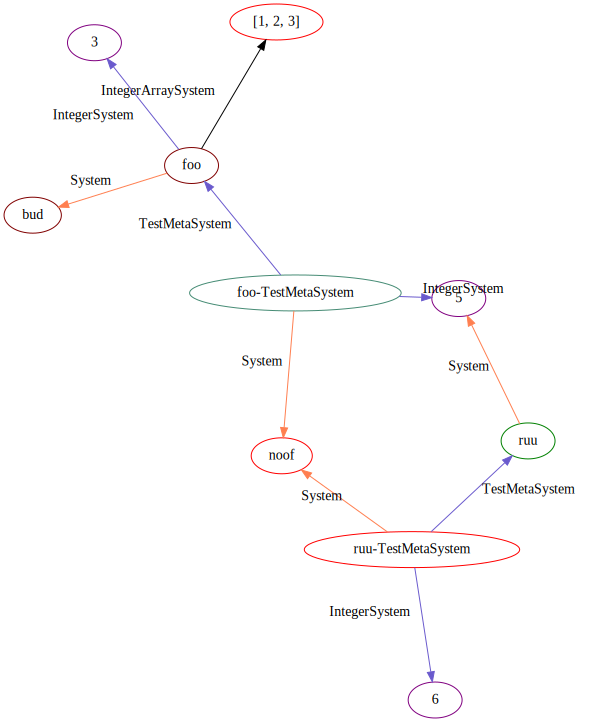

In [9]:
if __name__ == "__main__":
    qs.reset()
    var_s = System("foo", "bar")
    var_is = IntegerSystem("foo", 4)
    var_ias = IntegerArraySystem("foo", [1, 2, 3])

    assert QuantumSystem.get(edge_name=System) == [('foo', 'System', 'bar')]
    assert System.get_relationship("foo") == var_s.terminant == "bar"
    assert IntegerSystem.get_relationship("foo") == var_is.terminant == 4
    assert IntegerArraySystem.get_relationship("foo") == var_ias.terminant == [1, 2, 3]
    assert System.get_relationship("DNE") is None

    @IntegerSystem.sd
    @System.sd
    class TestHyperSystem(HyperSystem):
        """ Test HyperSystem """

    hypertest = TestHyperSystem("foo", "bud", "3")

    assert System.get_relationship("foo") == "bud" == hypertest.System.terminant
    assert IntegerSystem.get_relationship("foo") == 3 == hypertest.IntegerSystem.terminant
    assert hypertest == TestHyperSystem("foo")

    @IntegerSystem.sd
    @System.sd
    class TestMetaSystem(MetaSystem):
        """ MetaSystem Test """

    metatest = TestMetaSystem("foo", System="noof", IntegerSystem="5")

    assert TestMetaSystem.entities() == ["foo"]
    hyperEntities = TestHyperSystem.entities()
    assert len(hyperEntities) == 2
    assert 'foo' in hyperEntities
    assert 'foo-TestMetaSystem' in hyperEntities
    assert metatest == TestMetaSystem("foo") == TestMetaSystem("foo-TestMetaSystem")

    @TestMetaSystem.sd
    @System.sd
    class TestCompoundSystem(HyperSystem):
        """ Compound Test """
    
    compoundTest = TestCompoundSystem("ruu", TestMetaSystem={"System": "noof", "IntegerSystem": "6"}, System=5)

    metaEntities = TestMetaSystem.entities()
    assert len(hyperEntities) == 2
    assert 'foo' in metaEntities
    assert 'ruu' in metaEntities
    
    hyperEntities = TestHyperSystem.entities()
    assert len(hyperEntities) == 3
    assert 'foo' in hyperEntities
    assert'foo-TestMetaSystem' in hyperEntities
    assert 'ruu-TestMetaSystem' in hyperEntities
    compoundEntities = TestCompoundSystem.entities()
    assert len(compoundEntities) == 2
    assert 'foo' in compoundEntities
    assert 'ruu' in compoundEntities

    # Test graph save and restore
    old_whole_graph = qs.whole_graph()
    qs.write_graph_file()
    qs.reset()
    qs.read_graph_file()
    assert qs.whole_graph() == old_whole_graph
    
    display(qs.render())